In [1]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import napari

from pathlib import Path

In [2]:
path_image="data/anonymise_patient1.mhd"

In [3]:
image_imported = sitk.ReadImage(Path(path_image))

Quelques informations sur l'image importée.

In [4]:
selected_image = image_imported
print("Before modification:")
print("origin: " + str(selected_image.GetOrigin()))
print("size: " + str(selected_image.GetSize()))
print("spacing: " + str(selected_image.GetSpacing()))
print("direction: " + str(selected_image.GetDirection()))
print("pixel type: " + str(selected_image.GetPixelIDTypeAsString()))
print(
    "number of pixel components: " + str(selected_image.GetNumberOfComponentsPerPixel())
)


Before modification:
origin: (-232.0, -232.0, 754.0)
size: (512, 512, 1532)
spacing: (0.907, 0.907, 0.8)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 16-bit signed integer
number of pixel components: 1


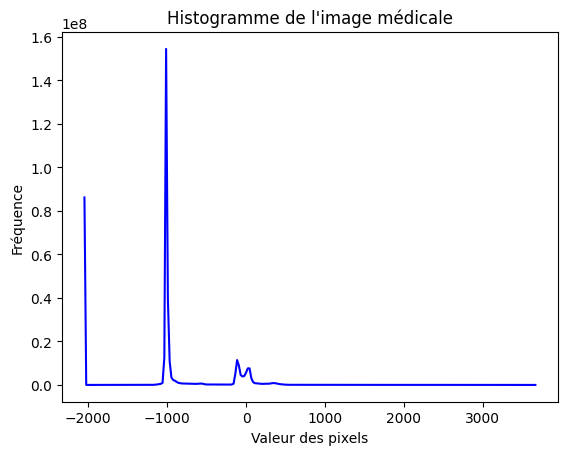

In [5]:
image_array = sitk.GetArrayFromImage(image_imported)
histogram, bin_edges = np.histogram(image_array.flatten(),bins=255)
plt.plot(bin_edges[0:-1], histogram, color='blue')
plt.title("Histogramme de l'image médicale")
plt.xlabel("Valeur des pixels")
plt.ylabel("Fréquence")
plt.show()

Transformation linéaire avec saturation, et changement de gamme dynamique : 0-255.

In [6]:
thresholdFilter = sitk.IntensityWindowingImageFilter()
thresholdFilter.SetWindowMinimum(0)
thresholdFilter.SetWindowMaximum(1000)
thresholdFilter.SetOutputMinimum(0)
thresholdFilter.SetOutputMaximum(255)
resultThreshold = thresholdFilter.Execute(image_imported)

Sauvegarde et visualisation de l'image.

In [7]:
SHOW_IN_NAPARI = False 
SAVE_IN_FILE = True

if SAVE_IN_FILE:
    image_array_threshold = sitk.GetArrayFromImage(resultThreshold)
    np.save(Path("temp/preprocessed_image.npy"), image_array_threshold)

In [8]:
if SHOW_IN_NAPARI:
    viewer = napari.Viewer()
    image_layer = viewer.add_image(image_array_threshold, colormap="gray")
    napari.run()